# PyCity Schools Analysis

* As a whole, schools with higher budgets, did not yield better test results. By contrast, schools with higher spending per student actually (\$645-675) underperformed compared to schools with smaller budgets (<\$585 per student).

* As a whole, smaller and medium sized schools dramatically out-performed large sized schools on passing math performances (89-91% passing vs 67%).

* As a whole, charter schools out-performed the public district schools across all metrics. However, more analysis will be required to glean if the effect is due to school practices or the fact that charter schools tend to serve smaller student populations per school. 
---

In [2]:

# Dependencies and Setup
import pandas as pd
import numpy as np
from pandas import pivot_table,DataFrame,crosstab
import matplotlib.pyplot as plt                                                 
 
# File to Load (Remember to Change These)
school_data_to_load = "schools_complete.csv"
student_data_to_load = "students_complete.csv"
# Read School and Student Data File and store into Pandas Data Frames
school_data = pd.read_csv(school_data_to_load)
                         
student_data = pd.read_csv(student_data_to_load)
#print("School count: " + str(df_schools))
# Combine the data into a single dataset
school_data_complete = pd.merge(student_data, school_data, how="left", on=["school_name", "school_name"])

In [3]:
## Useful Portable Routines

In [4]:
import numpy as np  
import pandas as pd  
from functools import partial

def summary(df, fn=np.sum, axis=0, name='Total',  
            table_class_prefix='dataframe-summary'):
    """Append a summary row or column to DataFrame.

    Input:
    ------
    df : Dataframe to be summarized
    fn : Summary function applied over each column
    axis : Axis to summarize on (1: by row, 0: by column)
    name : Index or column label for summary
    table_class_prefix : Custom css class for dataframe

    Returns:
    --------
    Dataframe with applied summary.

    """
    total = df.apply(fn, axis=axis).to_frame(name)

    table_class = ""

    if axis == 0:
        total = total.T
        table_class = "{}-row".format(table_class_prefix)
    elif axis == 1:
        table_class = "{}-col".format(table_class_prefix)

    out = pd.concat([df, total], axis=axis)
    # Patch to_html function to use custom css class
    out.to_html = partial(out.to_html, classes=table_class)
    return out

from numbers import Number

def as_percent(v, precision='0.2'):  
    """Convert number to percentage string."""
    if isinstance(v, Number):
        if v <=1:          
            return "{{:{}%}}".format(precision).format(v)
        elif((v>1) & (v<=100)):   
            v /= 100 #Divide by 100 if number is greater than 1, already formated for percentage
            return "{{:{}%}}".format(precision).format(v)
        else:
            return "{{:{}}}".format(precision).format(v) #number creater than 100%, this is only for 0 to 100% measurement    
    else:
        raise TypeError("Numeric type required")
        
def as_floater(v, precision='0.2'):  
    """Convert number to 'precision' place string."""
    if isinstance(v, Number):        
        return "{{:{}}}".format(precision).format(v)  
    else:
        raise TypeError("Numeric type required")
        
def as_dollary(v, precision='0.2'):  
    """Convert number to dollar string."""
    if isinstance(v, Number):      
        return "{{:${}}}".format(precision).format(v)  
    else:
        raise TypeError("Numeric type required")        

### Definitions I like to carry around

In [5]:
def fmat(df,fld,fm):
# INPUTS CAN BE 2,$,i,I,%,a% or just ',', FOR NUMBERS
    if type(fld) is list: #process the list if it is a list, this routine will
        
        for l in fld:
            if fm == "2":
                df[l] = df[l].map("{:,.2f}".format)
            elif fm == "$":
                df[l] =  df[l].map("${:,.2f}".format)
            elif fm == ",":
                df[l] =  df[l].map("{:,}".format)
            elif fm == "%":
                df[l] =  (df[l]*100).map("{:.2f}%".format)
            elif fm == "a%": #already is multiplied by 100, just need the % sign
                df[l] =  (df[l]).map("{:.2f}%".format)
            elif fm == "i":
                df[l] =  df[l].map("{:,.0f}".format)
            elif fm == "I":
                df[l] =  df[l].map("{:,.20f}".format)  
    else:
        if fm == "2":
            df[fld] = df[fld].map("{:,.2f}".format)
        elif fm == "$":
            df[fld] =  df[fld].map("${:,.2f}".format)
        elif fm == ",":
            df[fld] =  df[fld].map("{:,}".format)
        elif fm == "%":
            df[fld] =  (df[fld]*100).map("{:.2f}%".format)
        elif fm == "a%": #already is multiplied by 100, just need the % sign
            df[fld] =  (df[fld]).map("{:.2f}%".format)
        elif fm == "i":
            df[fld] =  df[fld].map("{:,.0f}".format)
        elif fm == "I":
            df[fld] =  df[fld].map("{:,.20f}".format)

        return df[fld]

#Routine for rotating last to first the columns of a datatable
def Rotate(df_Pivot):
    cols = df_Pivot.columns.tolist()
    cols=cols[-1:]+cols[:-1] #Rotates the list, last to first
    return df_Pivot[cols]

## Groupit Routine

In [6]:
def Groupitby(level1_4,Skip_Formatting=False):
     
#leve11_4 can be : type,school,grade,gender 


#Dictionary of Aggreations to pass on to Groupby
#This grouping is the most critical to this analysis because it is where
#the metrics are calculated by school.  The data has been prepared so that there
#are separate columns with 1 or 0 for Math, Reading and Overall
#by summing on those columns we can determine the number of students who 
#have passed math, reading and overall.

    aggregations={
                  "size":['count'], 
                  "reading_score":[np.mean],
                  "budget":[np.mean],
                  "math_score":[np.mean],
                  "PassMath": [sum],
                  "PassReading": [sum],
                  "OverallPass": [sum]
                 }
    #Group by District and School -  Summaries will by by School
    if level1_4 == 'type':
       df_distgrp = df.groupby(by=['type'], as_index=True).agg(aggregations)     
    elif level1_4 == 'school':
       df_distgrp = df.groupby(by=['type','school_name'], as_index=True).agg(aggregations)     
    elif level1_4 == 'grade':
       df_distgrp = df.groupby(by=['type','school_name','grade'], as_index=True).agg(aggregations) 
    elif level1_4 == 'gender':
       df_distgrp = df.groupby(by=['type','school_name','grade','gender'], as_index=True).agg(aggregations) 
    elif level1_4 == 'justschool':
       df_distgrp = df.groupby(by=['school_name'], as_index=True).agg(aggregations) 

    #Rename the columns according to a convention defined by the ravel routine
    #That actually makes it easier and quicker to name the output columns
    df_distgrp.columns =["_".join(x) for x in df_distgrp.columns.ravel()]
    #Define 4 new columns for our new Group, in this case the school Group
    df_distgrp['Cost/Student']=df_distgrp['budget_mean']/df_distgrp['size_count'] # do this AFTER the columns have been renamed by the line above
    df_distgrp['% Pass Math']=df_distgrp['PassMath_sum']/df_distgrp['size_count'] # do this AFTER the columns have been renamed by the line above 
    df_distgrp['% Pass Reading']=df_distgrp['PassReading_sum']/df_distgrp['size_count']# do this AFTER the columns have been renamed by the line above
    df_distgrp['% Combined']=df_distgrp['OverallPass_sum']/df_distgrp['size_count'] # do this AFTER the columns have been renamed by the line above

    #Now do some formatting of the output, but first copy the data
    #the fmat function is a the top of the code and used to 
    #format the columns, so if I want a global change, all i
    #do is make the change there.  
   # df_distgrpcopy = df_distgrp.copy # in case I need the unformatted data later
    if Skip_Formatting==False: #format the output, otherwise, just return the dataframe unadulterated
        df_distgrp['Cost/Student']=fmat(df_distgrp,'Cost/Student',"$")
        df_distgrp['% Pass Math']=fmat(df_distgrp,'% Pass Math',"%")
        df_distgrp['% Pass Reading']=fmat(df_distgrp,'% Pass Reading',"%")
        df_distgrp['% Combined']=fmat(df_distgrp,'% Combined',"%")
        df_distgrp['reading_score_mean']=fmat(df_distgrp,'reading_score_mean',"a%")
        df_distgrp['math_score_mean']=fmat(df_distgrp,'math_score_mean',"a%")
        df_distgrp['PassMath_sum']=fmat(df_distgrp,'PassMath_sum',"i")
        df_distgrp['PassReading_sum']=fmat(df_distgrp,'PassReading_sum',"i")
        df_distgrp['OverallPass_sum']=fmat(df_distgrp,'OverallPass_sum',"i")
        df_distgrp['budget_mean']=fmat(df_distgrp,'budget_mean',"$")
        
    return df_distgrp
 

In [7]:
#Groupitby('type',False)
    

### Simplifying DF names for myself

In [24]:
#Preview of School Data
print("School Data")
#school_data.head()
dfl = school_data
dfl.head()
#preview of Student data
print()
print("School-Student Merged Data")
#student_data.head()
dfs= student_data
df = school_data_complete  #shorter name for dataset
df.head()

School Data

School-Student Merged Data


,Student ID,student_name,gender,grade,school_name,reading_score,math_score,School ID,type,size,budget,Combined,PassMath,PassReading,OverallPass
0,0,Paul Bradley,M,9th,Huang High School,66,79,0,District,2917,1910635,72.5,1.0,0.0,1.0
1,1,Victor Smith,M,12th,Huang High School,94,61,0,District,2917,1910635,77.5,0.0,1.0,1.0
2,2,Kevin Rodriguez,M,12th,Huang High School,90,60,0,District,2917,1910635,75.0,0.0,1.0,1.0
3,3,Dr. Richard Scott,M,12th,Huang High School,67,58,0,District,2917,1910635,62.5,0.0,0.0,0.0
4,4,Bonnie Ray,F,9th,Huang High School,97,84,0,District,2917,1910635,90.5,1.0,1.0,1.0


## Data Preparation
We need to add a few columns to the merged file. There are basically two things going on here
    * 4 Columns are created
    * The values of three of the columns are created as TRUE or FALSE, then
    * Immediately mapped to 1 and 0 for math operations later.

In [29]:
#this is a fundamental criteria and should be easily adjustable.
#Many schools have a lower criteria for passing.  If 60 were
#using instead of 70 as is here, almost everyone in all the schools
#would pass!

PassCriteria = 70 #Necessary percentage in order to be considered passing
 
 
#this is a flattened data set of the school and student data.  i.e there is lots of redundancy
#in flattened data, but we have lots of memory....
#The question is, what additional columns do we need to add to the flattened file
#for the analysis. We need to know who passed math and reading and we nned an overall combination of those
#SCORES, and an analysis of overall passing.  the following fields will do the trick:

 
df['Combined']=(df['math_score']+df['reading_score'])/2 #average of math and reading for each student
df['PassMath'] = (df['math_score']>=PassCriteria).map({True:1,False:0}).astype(float) #a 1 or 0, pass or Fail, True or false -True mapped to 1 and False mapped to 0 so we can easily summarize in the grouping
df['PassReading']=(df['reading_score']>=PassCriteria).map({True:1,False:0}).astype(float) #a 1 or 0, pass or Fail, True or false -True mapped to 1 and False mapped to 0 so we can easily summarize in the grouping
df['OverallPass']= (df['Combined']>=PassCriteria).map({True:1,False:0}).astype(float)#a 1 or 0, pass or Fail, True or false -True mapped to 1 and False mapped to 0 so we can easily summarize in the grouping
 
#and then I figured out that I could comment them out and place the mapping on the original columns above.

#df['PassMath']=df['PassMath'].map({True:1,False:0})
#df['PassReading']=df['PassReading'].map({True:1,False:0})
#df['Combined']=df['Combined'].map({True:1,False:0})
 
df_Student_sorted =df.sort_values(['grade','Combined','student_name'],ascending=False)
#print(df_Student_sorted.head())

#print(df_Student_sorted.tail())
#

## Overall Quick Scan of data
### First, a quick summary of all the Student Level Data
Just because I wanted to...

In [30]:
#df_Student_sorted.describe()


### MINI OVER SUMMARY
This does a quick overview of the failure rates so
I have a feel for what is being determined.  Value_counts
will provide an overview of the variance of the data.  In this
case is an over view of scores is done, one can see that the data
is contrived, not natural.  There is not enough variation. 

In [31]:
#Quick check
print('Overall Students Pass/Fail in Math')
print(df_Student_sorted['PassMath'].value_counts(dropna=False))
print()
print('Overall Students Pass/Fail in Reading')
print(df_Student_sorted['PassReading'].value_counts(dropna=False))
print()
print('Overall Students Pass/Fail in Combined')
df_Student_sorted['OverallPass'].value_counts(dropna=False)


Overall Students Pass/Fail in Math
1.0    29370
0.0     9800
Name: PassMath, dtype: int64

Overall Students Pass/Fail in Reading
1.0    33610
0.0     5560
Name: PassReading, dtype: int64

Overall Students Pass/Fail in Combined


1.0    35013
0.0     4157
Name: OverallPass, dtype: int64

## PyCity Summary  aka District Summary
This data is put together piece by piece.  It is undoubtedly possible to sling the tables together in some fashion, and generate this info, but this way is quicker and very clear on how it works.

In [32]:
no_schools = len(dfl['School ID'].unique())
no_students =len(dfs['Student ID'].unique())
no_type =len(dfl['type'].unique())
TotBuget = dfl['budget'].sum()
AverageMath = df_Student_sorted['math_score'].mean()
AverageReading =df_Student_sorted['reading_score'].mean()
AverageOverall =(AverageMath + AverageReading)/2
PercentMath = df_Student_sorted['PassMath'].sum()/no_students
PercentReading =df_Student_sorted['PassReading'].sum()/no_students
PercentOverall =df_Student_sorted['OverallPass'].sum()/no_students

In [33]:
dfc =dfl.loc[dfl['type']=='Charter'] #fetch the Charter Schools
dfd= dfl.loc[dfl['type']=='District'] #fetch the District Schools
print()
print()
print("School count: " + str(no_schools))
print("Type School count: " + str(no_type))
print("Charter Schools:" + str(len(dfl.loc[dfl['type']=='Charter'])) + "->Students:" + str(len(dfc)))
print("District Schools:" + str(len(dfl.loc[dfl['type']=='District'])) + "->Students:" + str(len(dfd)))
print("City Student count: " + str(no_students))
print("Total Budget:" + str(TotBuget))
print("Average Math %:" + str(AverageMath))
print("Average Reading %:" + str(AverageReading))
print("Average Overall %:" + str(AverageOverall))
print("Pass Math %:" + str(PercentMath))
print("Pass Reading %:" + str(PercentReading))
print("Pass Overall %:" + str(PercentOverall))
print()



School count: 15
Type School count: 2
Charter Schools:8->Students:8
District Schools:7->Students:7
City Student count: 39170
Total Budget:24649428
Average Math %:78.98537145774827
Average Reading %:81.87784018381414
Average Overall %:80.43160582078121
Pass Math %:0.749808526933878
Pass Reading %:0.8580546336482001
Pass Overall %:0.893872861884095



### Transfer Tabular List to DataFrame

In [34]:
pyCitySum = [[no_schools,no_type,no_students,TotBuget,AverageMath,AverageReading,AverageOverall,PercentMath,PercentReading,PercentOverall]]

labels = ['Schools','Types','Students','Budget','Average Math','Average Reading',
                               'Average Overall','Passed Math%','Passed Reading %','Passed Overall %']
df_City=pd.DataFrame.from_records(pyCitySum,columns=labels)
df_City

,Schools,Types,Students,Budget,Average Math,Average Reading,Average Overall,Passed Math%,Passed Reading %,Passed Overall %
0,15,2,39170,24649428,78.985371,81.87784,80.431606,0.749809,0.858055,0.893873


### Now do the Grouping Exercise

In [37]:
df_distgrp=Groupitby('school',False) # Call to the Group Def
df_distgrp

size_count reading_score_mean    budget_mean  \
type     school_name                                                           
Charter  Cabrera High School          1858             83.98%  $1,081,356.00   
         Griffin High School          1468             83.82%    $917,500.00   
         Holden High School            427             83.81%    $248,087.00   
         Pena High School              962             84.04%    $585,858.00   
         Shelton High School          1761             83.73%  $1,056,600.00   
         Thomas High School           1635             83.85%  $1,043,130.00   
         Wilson High School           2283             83.99%  $1,319,574.00   
         Wright High School           1800             83.95%  $1,049,400.00   
District Bailey High School           4976             81.03%  $3,124,928.00   
         Figueroa High School         2949             81.16%  $1,884,411.00   
         Ford High School             2739             80.75%  $1,763,916.00   
         Hernandez High School        4635             80.93%  $3,022,020.00   
         Huang High School            2917             81.18%  $1,910,635.00   
         Johnson High School          4761             80.97%  $3,094,650.00   
         Rodriguez High School        3999             80.74%  $2,547,363.00   

                               math_score_mean PassMath_sum PassReading_sum  \
type     school_name                                                          
Charter  Cabrera High School            83.06%        1,749           1,803   
         Griffin High School            83.35%        1,371           1,426   
         Holden High School             83.80%          395             411   
         Pena High School               83.84%          910             923   
         Shelton High School            83.36%        1,653           1,688   
         Thomas High School             83.42%        1,525           1,591   
         Wilson High School             83.27%        2,143           2,204   
         Wright High School             83.68%        1,680           1,739   
District Bailey High School             77.05%        3,318           4,077   
         Figueroa High School           76.71%        1,946           2,381   
         Ford High School               77.10%        1,871           2,172   
         Hernandez High School          77.29%        3,094           3,748   
         Huang High School              76.63%        1,916           2,372   
         Johnson High School            77.07%        3,145           3,867   
         Rodriguez High School          76.84%        2,654           3,208   

                               OverallPass_sum Cost/Student % Pass Math  \
type     school_name                                                      
Charter  Cabrera High School             1,850      $582.00      94.13%   
         Griffin High School             1,460      $625.00      93.39%   
         Holden High School                421      $581.00      92.51%   
         Pena High School                  954      $609.00      94.59%   
         Shelton High School             1,750      $600.00      93.87%   
         Thomas High School              1,620      $638.00      93.27%   
         Wilson High School              2,266      $578.00      93.87%   
         Wright High School              1,786      $583.00      93.33%   
District Bailey High School              4,239      $628.00      66.68%   
         Figueroa High School            2,497      $639.00      65.99%   
         Ford High School                2,322      $644.00      68.31%   
         Hernandez High School           3,934      $652.00      66.75%   
         Huang High School               2,479      $655.00      65.68%   
         Johnson High School             4,046      $650.00      66.06%   
         Rodriguez High School           3,389      $637.00      66.37%   

                               % Pass Reading % Com

### Top Performing Schools (By Total Passing Rate)

In [38]:
df_sorted = df_distgrp.sort_values('% Combined',ascending=False)
df_sorted.head()


size_count reading_score_mean    budget_mean  \
type    school_name                                                         
Charter Cabrera High School        1858             83.98%  $1,081,356.00   
        Griffin High School        1468             83.82%    $917,500.00   
        Shelton High School        1761             83.73%  $1,056,600.00   
        Wilson High School         2283             83.99%  $1,319,574.00   
        Wright High School         1800             83.95%  $1,049,400.00   

                            math_score_mean PassMath_sum PassReading_sum  \
type    school_name                                                        
Charter Cabrera High School          83.06%        1,749           1,803   
        Griffin High School          83.35%        1,371           1,426   
        Shelton High School          83.36%        1,653           1,688   
        Wilson High School           83.27%        2,143           2,204   
        Wright High School           83.68%        1,680           1,739   

                            OverallPass_sum Cost/Student % Pass Math  \
type    school_name                                                    
Charter Cabrera High School           1,850      $582.00      94.13%   
        Griffin High School           1,460      $625.00      93.39%   
        Shelton High School           1,750      $600.00      93.87%   
        Wilson High School            2,266      $578.00      93.87%   
        Wright High School            1,786      $583.00      93.33%   

                            % Pass Reading % Combined  
type    school_name                                    
Charter Cabrera High School         97.04%     99.57%  
        Griffin High School         97.14%     99.46%  
        Shelton High School         95.85%     99.38%  
        Wilson High School          96.54%     99.26%  
        Wright High School          96.61%     99.22%

### Bottom Performing Schools (By Total Passing Rate)


In [39]:
#df_sorted = df_distgrp.sort_values('% Combined')

df_sorted.tail(5)

size_count reading_score_mean    budget_mean  \
type     school_name                                                           
District Johnson High School          4761             80.97%  $3,094,650.00   
         Hernandez High School        4635             80.93%  $3,022,020.00   
         Ford High School             2739             80.75%  $1,763,916.00   
         Rodriguez High School        3999             80.74%  $2,547,363.00   
         Figueroa High School         2949             81.16%  $1,884,411.00   

                               math_score_mean PassMath_sum PassReading_sum  \
type     school_name                                                          
District Johnson High School            77.07%        3,145           3,867   
         Hernandez High School          77.29%        3,094           3,748   
         Ford High School               77.10%        1,871           2,172   
         Rodriguez High School          76.84%        2,654           3,208   
         Figueroa High School           76.71%        1,946           2,381   

                               OverallPass_sum Cost/Student % Pass Math  \
type     school_name                                                      
District Johnson High School             4,046      $650.00      66.06%   
         Hernandez High School           3,934      $652.00      66.75%   
         Ford High School                2,322      $644.00      68.31%   
         Rodriguez High School           3,389      $637.00      66.37%   
         Figueroa High School            2,497      $639.00      65.99%   

                               % Pass Reading % Combined  
type     school_name                                      
District Johnson High School           81.22%     84.98%  
         Hernandez High School         80.86%     84.88%  
         Ford High School              79.30%     84.78%  
         Rodriguez High School         80.22%     84.75%  
         Figueroa High School          80.74%     84.67%

## Math Scores by Grade  
#### These are processed a bit differently than the homework.  One, they are done with pivot tables, which are more straight forward to work with than groupby.  The columns get sorted lexigraphically
so that the 9th grade is last.  To fix this, I call a routine that rotates the columns clockwise, so they end up in the correct order.   Second, I sort all of the scores using a multi-level sort
which prioritizes the grade levels in descending order. Third, I decorate the data frame with a summary line called average, that averages the columns, which is an indication of the PyCity
metrics.  And finally, I decorate each column with % signs by calling a routine.


In [40]:
df_Pivot = pd.pivot_table(df,index ='school_name',
                          values = 'math_score',
                          columns = 'grade',
                          aggfunc = np.mean)
 
df_rot = Rotate(df_Pivot)
df_sort1 = df_rot.sort_values(['12th','11th','10th','9th'],ascending=False)

df_sort=summary(df_sort1,fn=np.mean,name='Average',axis=0)
df_sort['9th'] = df_sort['9th'].apply(as_percent)
df_sort['10th'] = df_sort['10th'].apply(as_percent)
df_sort['11th'] = df_sort['11th'].apply(as_percent)
df_sort['12th'] = df_sort['12th'].apply(as_percent)
df_sort

grade,9th,10th,11th,12th
Pena High School,83.63%,83.37%,84.33%,84.12%
Shelton High School,83.42%,82.92%,83.38%,83.78%
Wright High School,83.26%,84.01%,83.84%,83.64%
Thomas High School,83.59%,83.09%,83.50%,83.50%
Griffin High School,82.04%,84.23%,83.84%,83.36%
Cabrera High School,83.09%,83.15%,82.77%,83.28%
Wilson High School,83.09%,83.72%,83.20%,83.04%
Holden High School,83.79%,83.43%,85.00%,82.86%
Rodriguez High School,76.86%,76.61%,76.40%,77.69%
Huang High School,77.03%,75.91%,76.45%,77.23%


## Reading Scores by Grade
 

In [41]:
df_Pivot = pd.pivot_table(df,index ='school_name',
                          values = 'reading_score',
                          columns = 'grade',
                          aggfunc = np.mean) 
df_rot = Rotate(df_Pivot)
df_sort1 = df_rot.sort_values(['12th','11th','10th','9th'],ascending=False)

df_sort=summary(df_sort1,fn=np.mean,name='Average',axis=0)
df_sort['9th'] = df_sort['9th'].apply(as_percent)
df_sort['10th'] = df_sort['10th'].apply(as_percent)
df_sort['11th'] = df_sort['11th'].apply(as_percent)
df_sort['12th'] = df_sort['12th'].apply(as_percent)
 
df_sort

grade,9th,10th,11th,12th
Holden High School,83.68%,83.32%,83.82%,84.70%
Pena High School,83.81%,83.61%,84.34%,84.59%
Wilson High School,83.94%,84.02%,83.76%,84.32%
Cabrera High School,83.68%,84.25%,83.79%,84.29%
Wright High School,83.83%,83.81%,84.16%,84.07%
Griffin High School,83.37%,83.71%,84.29%,84.01%
Thomas High School,83.73%,84.25%,83.59%,83.83%
Shelton High School,84.12%,83.44%,84.37%,82.78%
Figueroa High School,81.20%,81.41%,80.64%,81.38%
Johnson High School,81.26%,80.77%,80.62%,81.23%


## Scores by School Spending

In [42]:
# Sample bins. Feel free to create your own bins.
df_School = Groupitby('justschool',True) # Dont format the data

spending_bins = [0, 585, 615, 645, 685]
group_names = ["<$585", "$585-615", "$615-645", "$645-675"]
dfcopy = df_School.copy()
dfcopy['Cost Group'] = pd.cut(x=df_School['Cost/Student'],bins=spending_bins,labels=group_names)
dfcopy['% Pass Reading'] = dfcopy['% Pass Reading']*100
dfcopy['% Pass Math'] = dfcopy['% Pass Math']*100
dfcopy['% Combined'] = dfcopy['% Combined']*100

dfcopy.head(2) # note the Cost Group column that has been appended to the data table. that is what CUT has done

,size_count,reading_score_mean,budget_mean,math_score_mean,PassMath_sum,PassReading_sum,OverallPass_sum,Cost/Student,% Pass Math,% Pass Reading,% Combined,Cost Group
school_name,,,,,,,,,,,,
Bailey High School,4976,81.033963,3124928,77.048432,3318.0,4077.0,4239.0,628.0,66.680064,81.933280,85.188907,$615-645
Cabrera High School,1858,83.975780,1081356,83.061895,1749.0,1803.0,1850.0,582.0,94.133477,97.039828,99.569429,<$585


,% Combined,% Pass Math,% Pass Reading,math_score_mean,reading_score_mean
Cost Group,,,,,
<$585,99.16%,93.46%,96.61%,83.46%,83.93%
$585-615,99.27%,94.23%,95.90%,83.60%,83.89%
$615-645,89.65%,75.67%,86.11%,79.08%,81.89%
$645-675,84.95%,66.16%,81.13%,77.00%,81.03%
Combined,92.53%,80.99%,89.22%,80.43%,82.53%


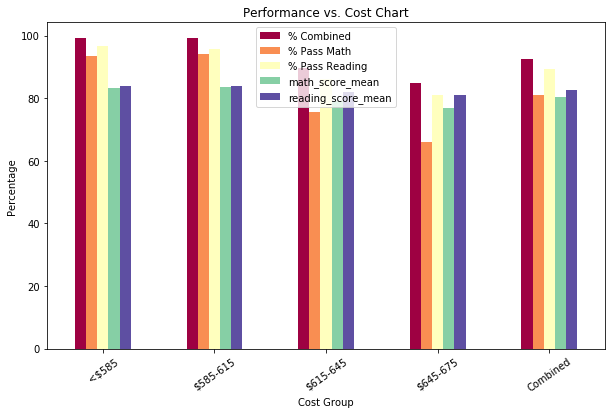

In [46]:
#Now that I have a modified Data table I can GroupBy or Pivot
df_binPivot = pd.pivot_table(dfcopy, index='Cost Group',values=['math_score_mean','reading_score_mean','% Pass Math','% Pass Reading','% Combined'],aggfunc ='mean',margins=True,margins_name="Combined")
# before I screw up the data with formatting
ax =df_binPivot.plot(kind='bar' ,figsize=(10,6),title="Performance vs. Cost Chart",colormap='Spectral',rot=35,grid=False)
ax.set_ylabel("Percentage")
ax.can_zoom=True
#print(dir(ax))
dflistpc =['% Pass Math','% Pass Reading','% Combined'] # list of percent items to process where the number is less than or equal to one
dflistapc=['math_score_mean','reading_score_mean'] # list of percent items where the only thing need is to round to two places and put a %
fmat(df_binPivot,dflistapc,"a%") 
fmat(df_binPivot,dflistpc,"a%")
#

df_binPivot


## Scores by School Size

,% Combined,% Pass Math,% Pass Reading,math_score_mean,reading_score_mean
Size Group,,,,,
Small (<1000),98.88%,93.55%,96.10%,83.82%,83.93%
Medium (1000-2000),99.34%,93.60%,96.79%,83.37%,83.86%
Large (2000-5000),86.69%,69.96%,82.77%,77.75%,81.34%
Combined,92.53%,80.99%,89.22%,80.43%,82.53%


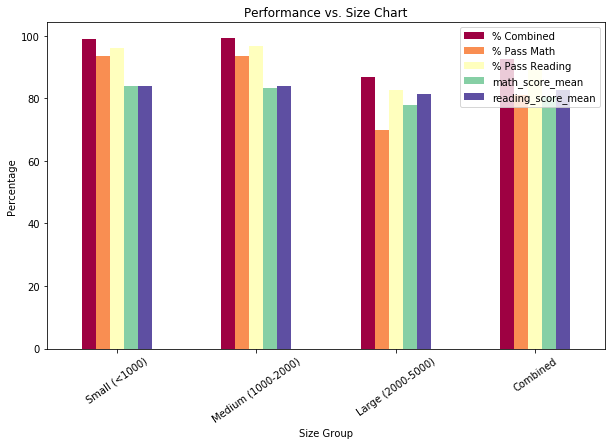

In [47]:
# Sample bins. Feel free to create your own bins.
size_bins = [0, 1000, 2000, 5000]
group_names = ["Small (<1000)", "Medium (1000-2000)", "Large (2000-5000)"]
# Sample bins. Feel free to create your own bins.
df_School = Groupitby('justschool',True) # Dont format the data


dfcopy = df_School.copy()
dfcopy['Size Group'] = pd.cut(x=df_School['size_count'],bins=size_bins,labels=group_names)
dfcopy['% Pass Reading'] = dfcopy['% Pass Reading']*100
dfcopy['% Pass Math'] = dfcopy['% Pass Math']*100
dfcopy['% Combined'] = dfcopy['% Combined']*100

#Now that I have a modified Data table I can GroupBy or Pivot
df_binPivot = pd.pivot_table(dfcopy, index='Size Group',values=['math_score_mean','reading_score_mean','% Pass Math','% Pass Reading','% Combined'],aggfunc ='mean',margins=True,margins_name="Combined")
# before I screw up the data with formatting
ax =df_binPivot.plot(kind='bar' ,figsize=(10,6),title="Performance vs. Size Chart",colormap='Spectral',rot=35,grid=False)
ax.set_ylabel("Percentage")
ax.can_zoom=True
#print(dir(ax))
dflistpc =['% Pass Math','% Pass Reading','% Combined'] # list of percent items to process where the number is less than or equal to one
dflistapc=['math_score_mean','reading_score_mean'] # list of percent items where the only thing need is to round to two places and put a %
fmat(df_binPivot,dflistapc,"a%") 
fmat(df_binPivot,dflistpc,"a%")
#

df_binPivot

## Scores by School Type

In [23]:
df_type=Groupitby('type') #call to the grouper
#removecol = ['size_count','budget_mean','PassMath_sum','PassReading_sum','OverallPass_sum','Cost/Student']
df_type.drop(df_type.columns[[0,2,4,5,6,7]],axis=1,inplace=True)
df_type

,reading_score_mean,math_score_mean,% Pass Math,% Pass Reading,% Combined
type,,,,,
Charter,83.90%,83.41%,93.70%,96.65%,99.29%
District,80.96%,76.99%,66.52%,80.91%,84.91%


#### Note: The way I calculated the overall is different from the example provided in the homework; whereas the example averages the passing percentage, I average the scores, and use that as the metric.  At any rate, right or wrong, there are different ways of looking at the data that are equally legit, but can have signifcant impact on people's lives.  In this case, the difference is about 10% overall between the two methods, or about 3500 kids that would fail to graduate because of a calculation method by a data analyst.

There is a dramatic difference between charter and district schools.  Without deeper knowledge about the charter schools, such as whether they are also funded directly by the students' parents, or the general socio-economic class of different schools, it is not possible to determine from this report why descrepancies exist, but this report clearly shows that there are significant differences in the attained competency of the students.



